# Setup

In [2]:
import os
# path = input("Enter the path:")
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir(path)

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from collections import Counter
from imblearn.combine import SMOTEENN
import random
from xgboost import XGBClassifier
from sklearn.naive_bayes import ComplementNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
import joblib
from sklearn.model_selection import KFold
from dask.distributed import Client
client = Client(processes=False)

In [3]:
import util as ut

# Importing Data

In [4]:
# path = r'D:\Projects\HR-Analytics\HR Analytics\Data'
path = input("Enter the data path:")

In [5]:
train = pd.read_csv(os.path.join(path,"train.csv"))

In [6]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [7]:
train.shape

(54808, 14)

# Checking for missing values


In [8]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [9]:
train.isnull().sum()/train.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

Only 7.5% of values are missing for previous_year_rating and 4.4% for education. Which means we will have to impute these values, rather than deleting the columns. Let us fill these values with 0.0 for previous year ratings and 'other' for education

In [10]:
train['education'].fillna('null',inplace=True)
train['previous_year_rating'].fillna(0.0,inplace=True) 

In [11]:
train.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [12]:
print(train['education'].value_counts())
print(train['previous_year_rating'].value_counts())

education
Bachelor's          36669
Master's & above    14925
null                 2409
Below Secondary       805
Name: count, dtype: int64
previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
0.0     4124
Name: count, dtype: int64


# Feature Engineering

In [13]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [14]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


A few insights from EDA and observation:

1. KPIs_met >80%, awards_won? and is_promoted have only 2 unique values, these can be converted into categorical variables.

2. employee_id is an id, which won't provide us with insights

3. no_of_trainings: Maximum number of employees have completed only 1 training. This can be converted into a categorical variable,is_multiple_training_completed.

4. There are multiple sparse values for region, which we can merge.

We can uncover greater insights, from further analysis

We can also store the total count of employees having same region,gender,recruitment_channel and department, for each employee to see how those factors matter for promotion.

In [15]:
columns = ['gender','region','department','recruitment_channel']

for column in columns:
  d = {}
  for value in train[column].unique():
    d[value] = train.loc[train[column] == value][column].shape[0]

  train[column+'_count'] = train[column].apply(lambda x:d[x])
  # print(train[column+'_count'].head())
  # print(train[column+'_count'].value_counts())

In [16]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,region_count,department_count,recruitment_channel_count
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,16312,4843,16840,23220
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,38496,6428,11348,30446
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,38496,874,16840,23220
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,38496,1175,16840,30446
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,38496,2260,7138,30446


In [18]:
train['KPIs_met >80%'] = ut.convert_to_categorical(train,'KPIs_met >80%')
train['awards_won?'] = ut.convert_to_categorical(train,'awards_won?')
train['is_promoted'] = ut.convert_to_categorical(train,'is_promoted')

In [20]:
train = ut.cont_to_cat(train,'is_multiple_training_completed','no_of_trainings')

is_multiple_training_completed
0    44378
1    10430
Name: count, dtype: int64


From eda done earlier, we can infer that age and lenght of service don't provide much information, but they can be binned in order to do so. 

In [21]:
bins = [-1,2,5,7,10,train['length_of_service'].max()]
labels = ['0-2','3-5','5-7','8-10','more_than_10']
train['length_of_service_binned'] = pd.cut(train['length_of_service'], bins,labels=labels)


bins = [-1, 29, 39, 49,train['age'].max()]
labels = ['less_than_30','30-39','40-49','more_equal_to_50']
train['age_binned'] = pd.cut(train['age'], bins,labels=labels)

In [22]:
train.drop(['employee_id'],axis=1,inplace=True)

In [23]:
train.shape

(54808, 20)

In [24]:
train.dtypes

department                          object
region                              object
education                           object
gender                              object
recruitment_channel                 object
no_of_trainings                      int64
age                                  int64
previous_year_rating               float64
length_of_service                    int64
KPIs_met >80%                       object
awards_won?                         object
avg_training_score                   int64
is_promoted                         object
gender_count                         int64
region_count                         int64
department_count                     int64
recruitment_channel_count            int64
is_multiple_training_completed      object
length_of_service_binned          category
age_binned                        category
dtype: object

In [25]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,region_count,department_count,recruitment_channel_count,is_multiple_training_completed,length_of_service_binned,age_binned
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,16312,4843,16840,23220,0,8-10,30-39
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,38496,6428,11348,30446,0,3-5,30-39
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,38496,874,16840,23220,0,5-7,30-39
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,38496,1175,16840,30446,1,8-10,30-39
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,38496,2260,7138,30446,0,0-2,40-49


In [27]:
num_cols, cat_cols = ut.get_dtypes(train)
# since is_promoted is a dependent variable and we will perform transformations on independent variables only, we remove it from cat_cols column and store it in target variable.
cat_cols.remove('is_promoted') 
target = 'is_promoted' 

In [28]:
num_cols,cat_cols

(['no_of_trainings',
  'age',
  'previous_year_rating',
  'length_of_service',
  'avg_training_score',
  'gender_count',
  'region_count',
  'department_count',
  'recruitment_channel_count',
  'length_of_service_binned',
  'age_binned'],
 ['department',
  'region',
  'education',
  'gender',
  'recruitment_channel',
  'KPIs_met >80%',
  'awards_won?',
  'is_multiple_training_completed'])

In [30]:
ut.get_unique_instances(train,num_cols)

no_of_trainings - Number of Unique Values: 10
age - Number of Unique Values: 41
previous_year_rating - Number of Unique Values: 6
length_of_service - Number of Unique Values: 35
avg_training_score - Number of Unique Values: 61
gender_count - Number of Unique Values: 2
region_count - Number of Unique Values: 34
department_count - Number of Unique Values: 8
recruitment_channel_count - Number of Unique Values: 3
length_of_service_binned - Number of Unique Values: 5
age_binned - Number of Unique Values: 4


There are quite a few unique values for our numerical variables, hence we won't convert them to categorical variables.

In [31]:
ut.get_unique_instances(train,cat_cols)

department - Number of Unique Values: 9
region - Number of Unique Values: 34
education - Number of Unique Values: 4
gender - Number of Unique Values: 2
recruitment_channel - Number of Unique Values: 3
KPIs_met >80% - Number of Unique Values: 2
awards_won? - Number of Unique Values: 2
is_multiple_training_completed - Number of Unique Values: 2


1. There are many unique regions in the data, we will combine sparse classes for this attributes.
2. By peeking into data, we can infer that education,KPIs_met >80%,awards_won and is_multiple_training_completed are ordinal variables. We will have to perform label encoding for education. The rest are already in label encoded from(0's and 1's.)

In [32]:
train['region'].value_counts() 

region
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: count, dtype: int64

We can group the regions according to the number of employees working at each region. Let' say we divide region into 2 parts, having employees > 2000 and less than 2000 into variable region_high_employees.

In [33]:
more_than_2000 = ['region_2','region_22','region_7','region_15','region_13','region_26']

temp = []
no_rows = train.shape[0]
print(no_rows)
for i in range(0, no_rows):
  if train['region'][i] in more_than_2000:
    temp.append(1)
  else:
    temp.append(0)


train['region_high_employees'] = pd.Series(temp).astype('object')
print(train['region_high_employees'].value_counts())
print(train['region_high_employees'].value_counts(normalize=True))

54808
region_high_employees
1    31330
0    23478
Name: count, dtype: int64
region_high_employees
1    0.571632
0    0.428368
Name: proportion, dtype: float64


More than 57% of employees belong to 6 regions, while remaining 23 represent 43%. 

Region high employees is an ordinal variable, since it signifies the employee strength in a region. We will not need to label encode it since it's already in 0/1 format. 

In [34]:
train.drop(['region'],axis=1,inplace=True)
cat_cols.append('region_high_employees')
cat_cols.remove('region')

In [35]:
train.shape

(54808, 20)

## Encoding for categorical variables

In [36]:
cat_cols

['department',
 'education',
 'gender',
 'recruitment_channel',
 'KPIs_met >80%',
 'awards_won?',
 'is_multiple_training_completed',
 'region_high_employees']

In [37]:
train[cat_cols].head()

,department,education,gender,recruitment_channel,KPIs_met >80%,awards_won?,is_multiple_training_completed,region_high_employees
0,Sales & Marketing,Master's & above,f,sourcing,1,0,0,1
1,Operations,Bachelor's,m,other,0,0,0,1
2,Sales & Marketing,Bachelor's,m,sourcing,0,0,0,0
3,Sales & Marketing,Bachelor's,m,other,0,0,1,0
4,Technology,Bachelor's,m,other,0,0,0,1


In [38]:
nominal = ['department','recruitment_channel','length_of_service_binned','age_binned','gender'] 
ordinal = ['education', 'KPIs_met >80%', 'awards_won?', 'is_multiple_training_completed', 'region_high_employees']

In [40]:
train = ut.one_hot_encoding(train,nominal)

In [41]:
train.head()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,...,length_of_service_binned_3-5,length_of_service_binned_5-7,length_of_service_binned_8-10,length_of_service_binned_more_than_10,age_binned_less_than_30,age_binned_30-39,age_binned_40-49,age_binned_more_equal_to_50,gender_f,gender_m
0,Master's & above,1,35,5.0,8,1,0,49,0,16312,...,False,False,True,False,False,True,False,False,True,False
1,Bachelor's,1,30,5.0,4,0,0,60,0,38496,...,True,False,False,False,False,True,False,False,False,True
2,Bachelor's,1,34,3.0,7,0,0,50,0,38496,...,False,True,False,False,False,True,False,False,False,True
3,Bachelor's,2,39,1.0,10,0,0,50,0,38496,...,False,False,True,False,False,True,False,False,False,True
4,Bachelor's,1,45,3.0,2,0,0,73,0,38496,...,False,False,False,False,False,False,True,False,False,True


In [42]:
train['education'].value_counts()

education
Bachelor's          36669
Master's & above    14925
null                 2409
Below Secondary       805
Name: count, dtype: int64

We can assign numeric values to education as follows:
0 - null
1 - Below Secondary
2- Bachelors
3 - Masters and above

In [43]:
train['education'] = train['education'].map({'null':0,'Below Secondary':1,"Bachelor's":2,"Master's & above":3})
print(train['education'].value_counts())

education
2    36669
3    14925
0     2409
1      805
Name: count, dtype: int64


In [44]:
train.shape

(54808, 38)

Since we've already converted the attributes into numerical form, let's also convert the attribute datatype to integer, which will make it easier to use for dimensionality reduction and modelling.

In [45]:
train.dtypes

education                                  int64
no_of_trainings                            int64
age                                        int64
previous_year_rating                     float64
length_of_service                          int64
KPIs_met >80%                             object
awards_won?                               object
avg_training_score                         int64
is_promoted                               object
gender_count                               int64
region_count                               int64
department_count                           int64
recruitment_channel_count                  int64
is_multiple_training_completed            object
region_high_employees                     object
department_Analytics                      object
department_Finance                        object
department_HR                             object
department_Legal                          object
department_Operations                     object
department_Procureme

In [46]:
for variable in train.columns:
  if(train[variable].dtypes == "object"): 
    #print(variable)
    train[variable] = train[variable].apply(lambda x:int(x))

In [47]:
# Since there are only 2 genders in the dataset, male and female, one of gender_m and gender_f can represent the relevant information. 

#Dropping gender_f variable.
train.drop(['gender_f'],axis=1,inplace=True,errors='ignore')

In [48]:
train.dtypes

education                                  int64
no_of_trainings                            int64
age                                        int64
previous_year_rating                     float64
length_of_service                          int64
KPIs_met >80%                              int64
awards_won?                                int64
avg_training_score                         int64
is_promoted                                int64
gender_count                               int64
region_count                               int64
department_count                           int64
recruitment_channel_count                  int64
is_multiple_training_completed             int64
region_high_employees                      int64
department_Analytics                       int64
department_Finance                         int64
department_HR                              int64
department_Legal                           int64
department_Operations                      int64
department_Procureme

In [49]:
train.shape

(54808, 37)

## Numerical variables processing


In [50]:
num_cols.remove('length_of_service_binned')
num_cols.remove('age_binned')
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score',
 'gender_count',
 'region_count',
 'department_count',
 'recruitment_channel_count']

In [51]:
train.columns

Index(['education', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted', 'gender_count', 'region_count',
       'department_count', 'recruitment_channel_count',
       'is_multiple_training_completed', 'region_high_employees',
       'department_Analytics', 'department_Finance', 'department_HR',
       'department_Legal', 'department_Operations', 'department_Procurement',
       'department_R&D', 'department_Sales & Marketing',
       'department_Technology', 'recruitment_channel_other',
       'recruitment_channel_referred', 'recruitment_channel_sourcing',
       'length_of_service_binned_0-2', 'length_of_service_binned_3-5',
       'length_of_service_binned_5-7', 'length_of_service_binned_8-10',
       'length_of_service_binned_more_than_10', 'age_binned_less_than_30',
       'age_binned_30-39', 'age_binned_40-49', 'age_binned_more_equal_to_50',
       'gender_m'],
      dtype='object

In [52]:
train[num_cols].dtypes

no_of_trainings                int64
age                            int64
previous_year_rating         float64
length_of_service              int64
avg_training_score             int64
gender_count                   int64
region_count                   int64
department_count               int64
recruitment_channel_count      int64
dtype: object

In [53]:
# changing previous_year_rating to int since it has discrete values
train['previous_year_rating'] = train['previous_year_rating'].apply(lambda x:int(x)) #train['previous_year_rating']

In [54]:
train[num_cols].dtypes

no_of_trainings              int64
age                          int64
previous_year_rating         int64
length_of_service            int64
avg_training_score           int64
gender_count                 int64
region_count                 int64
department_count             int64
recruitment_channel_count    int64
dtype: object

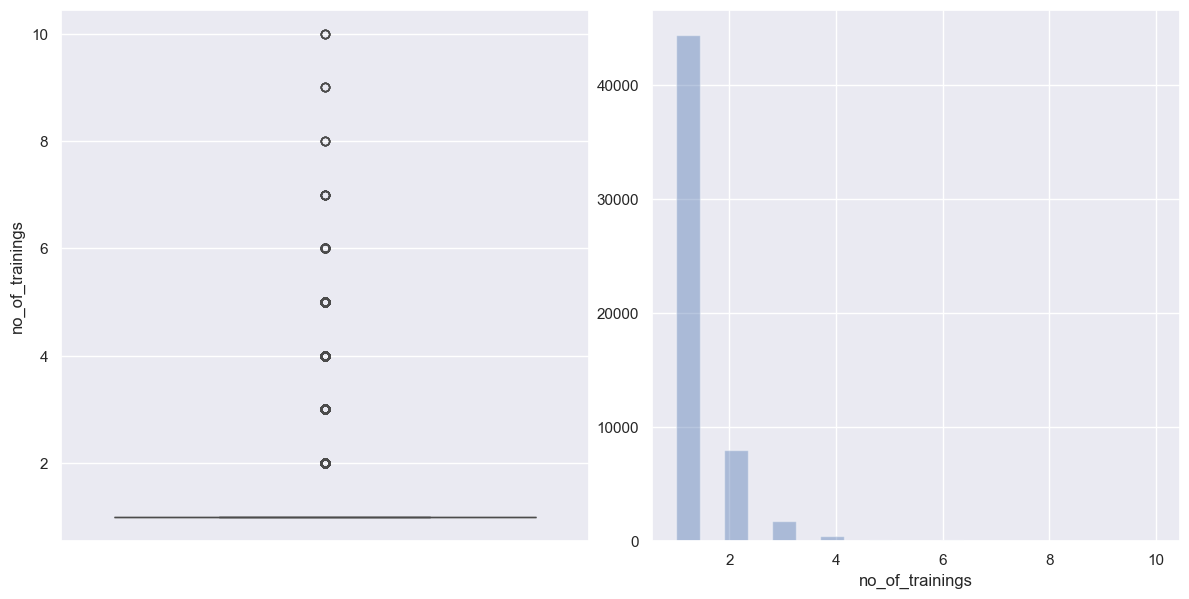

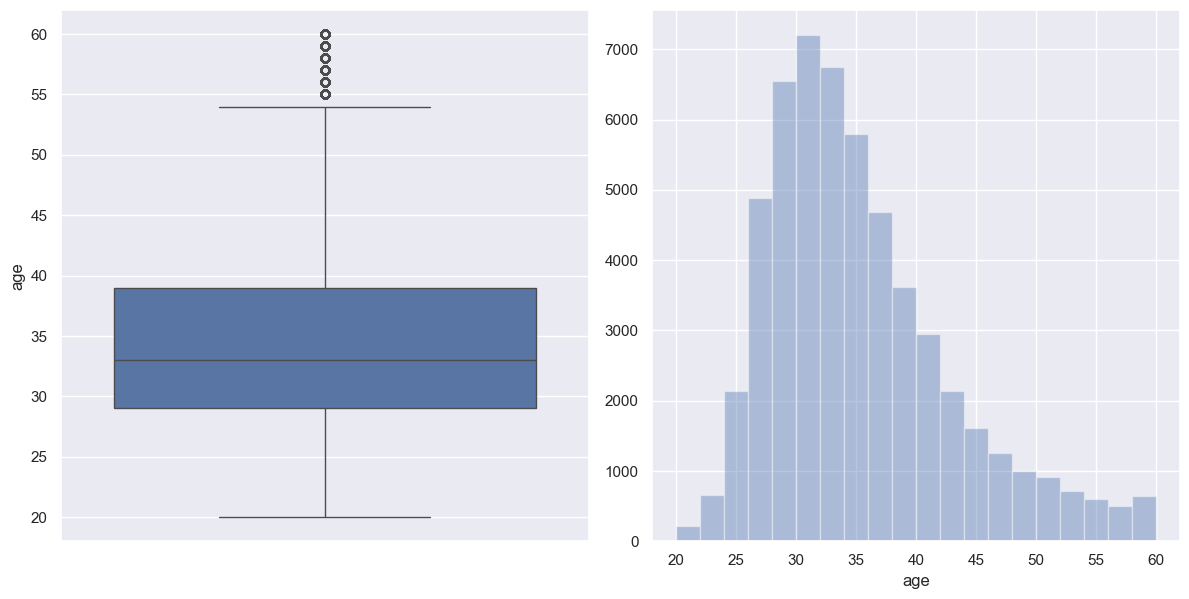

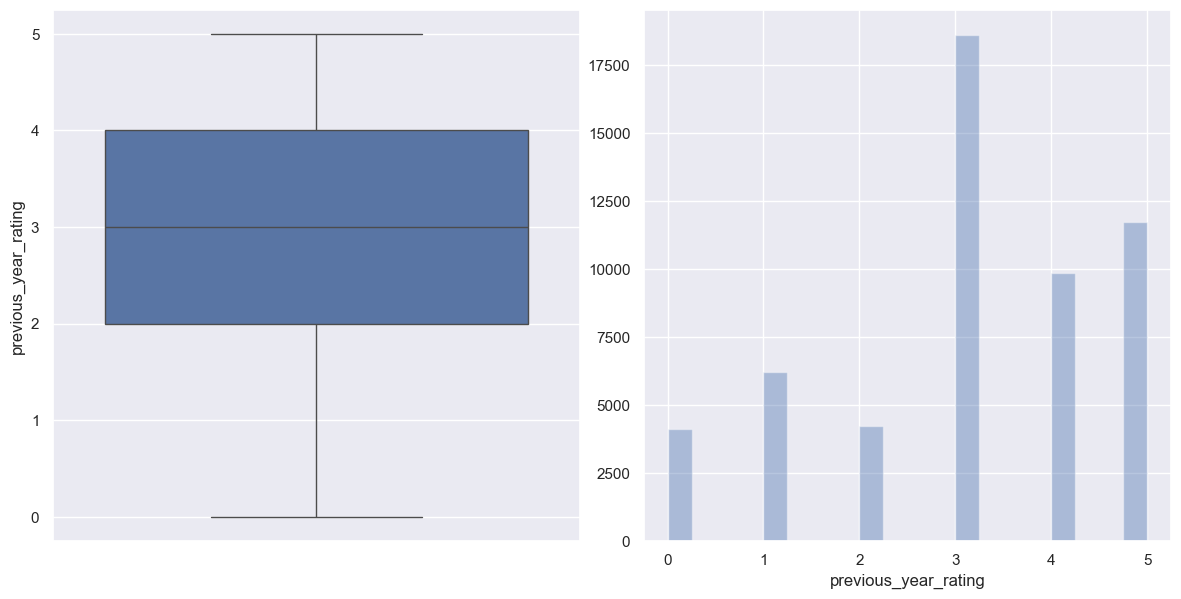

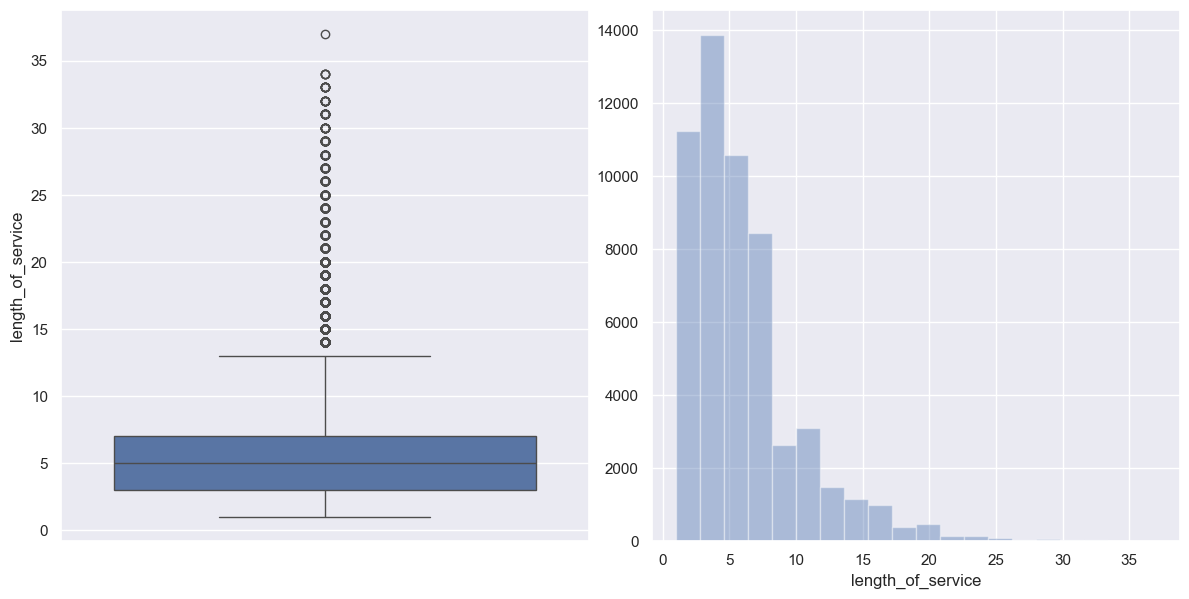

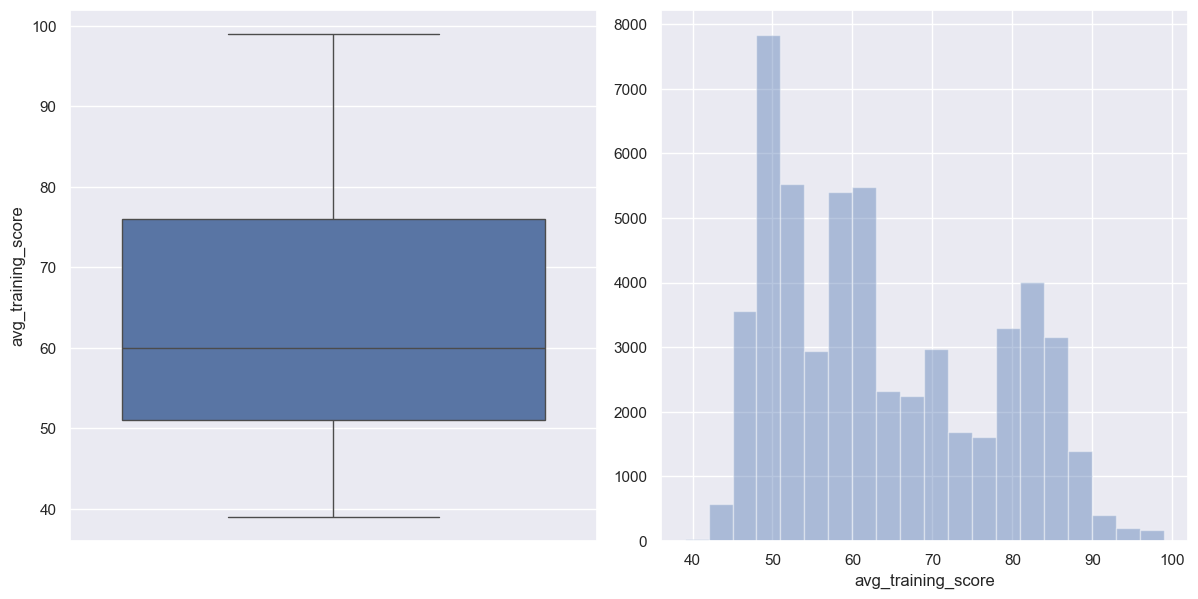

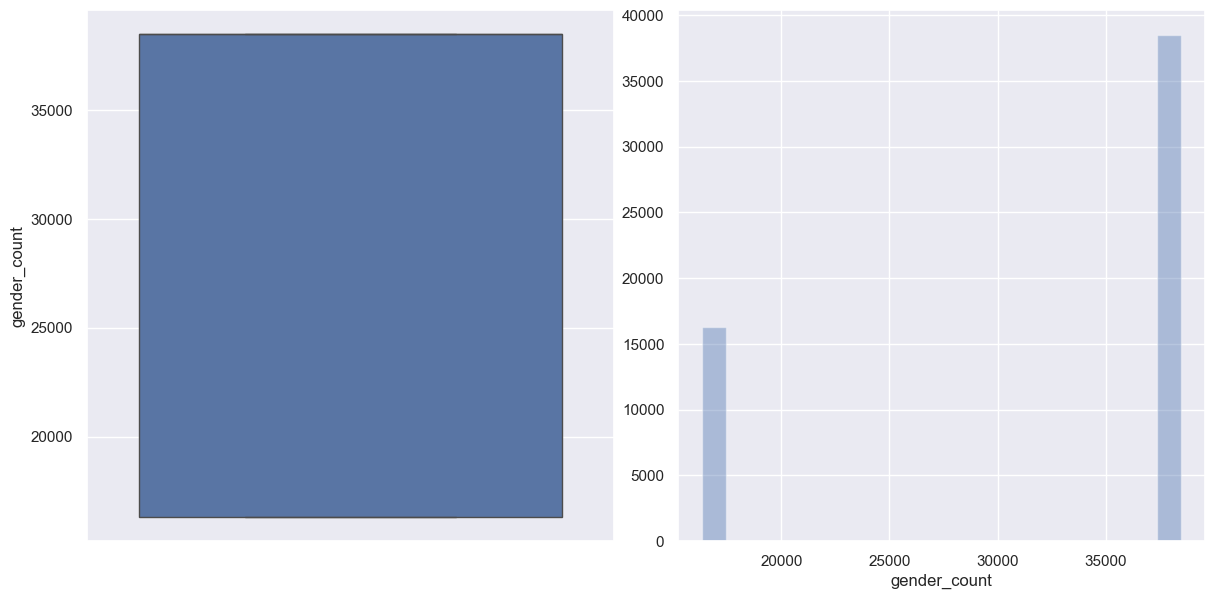

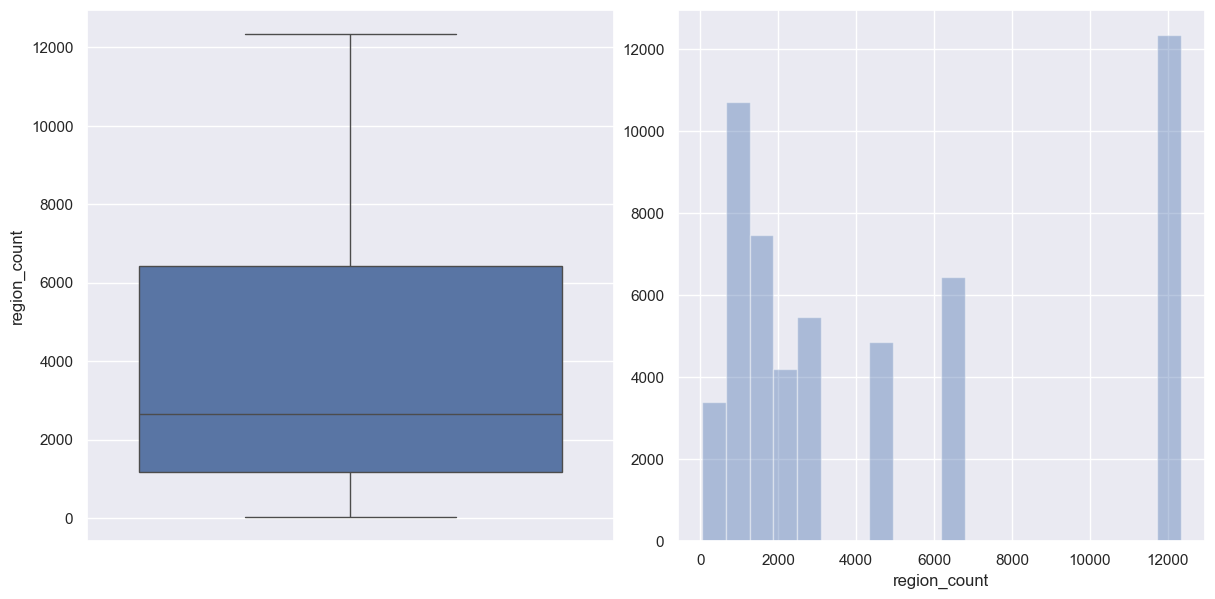

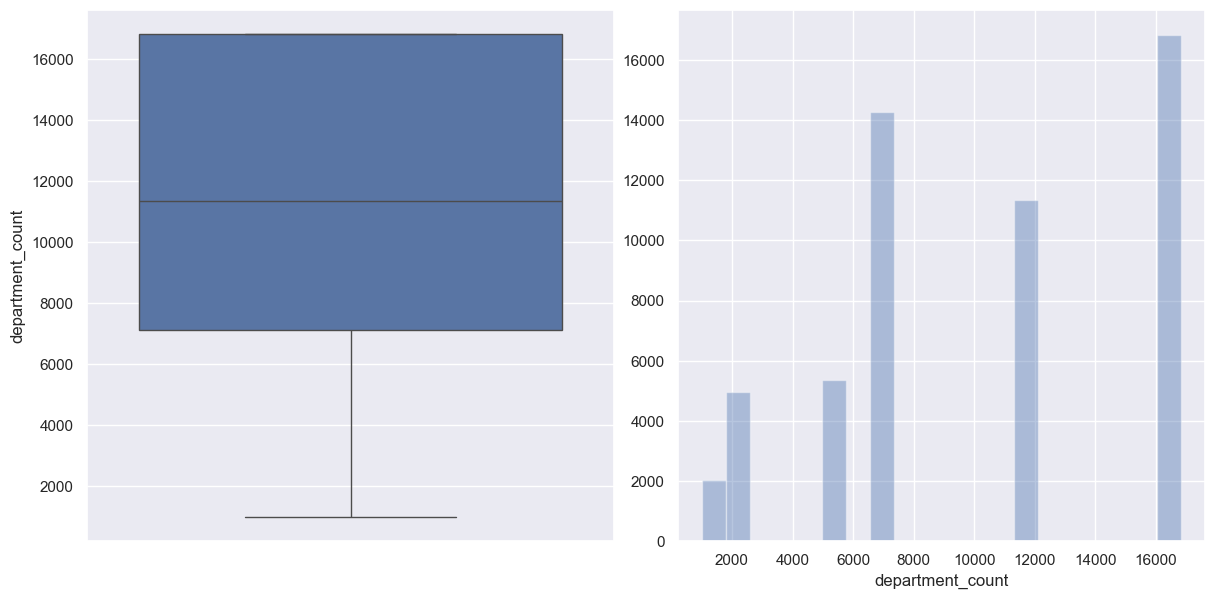

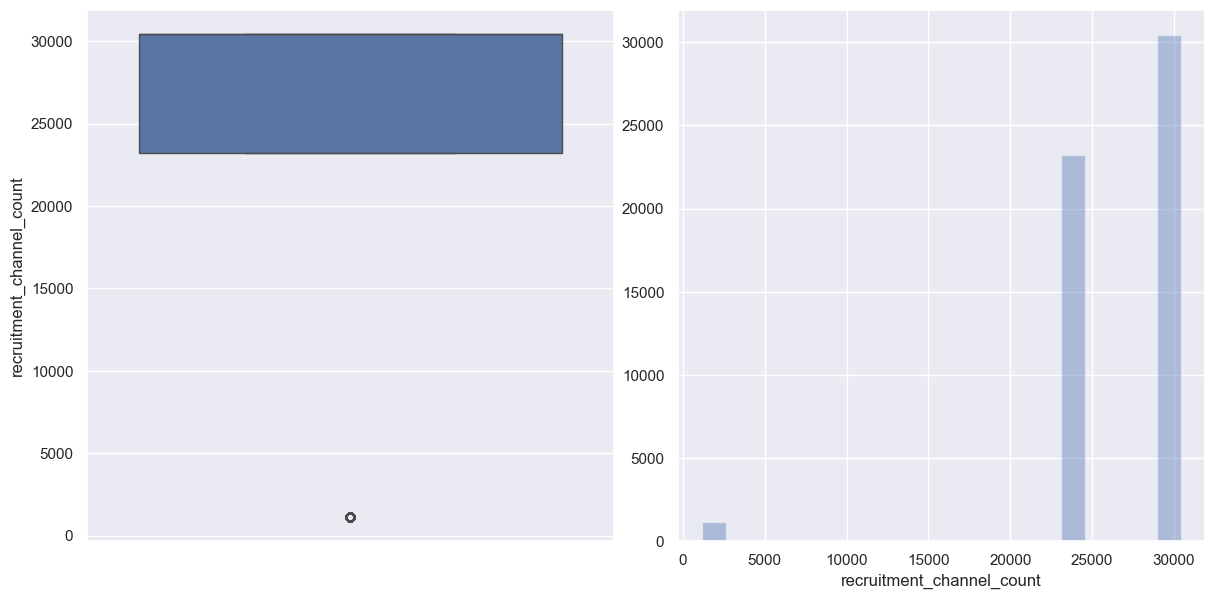

In [56]:
for col in num_cols:
  # print("For column name: ",col)
  ut.plot_numerical(train[col])
  # print("---------------------------------")

All our numerical columns  can have genuine outliers(lower/higher values). 
Hence **we will not be processing outliers** in this case. 
Following can be induced for each variable from the above plots

1. previous_year_rating: The actual ratings are between 1 and 5, while 0 is a placeholder value for null values. No outliers(since all vals are between 0-5) and distribution is somewhat normal, so we do not require any transformations
3. avg_training_score: Training scores are between 40-100, hence outliers can be genuine.  The distribution is slightly right-skewed.

Let's scale the numeric variables and then visualize them again

In [57]:
train_copy = train.copy()

In [58]:
train.head()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,...,length_of_service_binned_0-2,length_of_service_binned_3-5,length_of_service_binned_5-7,length_of_service_binned_8-10,length_of_service_binned_more_than_10,age_binned_less_than_30,age_binned_30-39,age_binned_40-49,age_binned_more_equal_to_50,gender_m
0,3,1,35,5,8,1,0,49,0,16312,...,0,0,0,1,0,0,1,0,0,0
1,2,1,30,5,4,0,0,60,0,38496,...,0,1,0,0,0,0,1,0,0,1
2,2,1,34,3,7,0,0,50,0,38496,...,0,0,1,0,0,0,1,0,0,1
3,2,2,39,1,10,0,0,50,0,38496,...,0,0,0,1,0,0,1,0,0,1
4,2,1,45,3,2,0,0,73,0,38496,...,1,0,0,0,0,0,0,1,0,1


Let's try log-transforming skewed variables(avg_training_score and no_of_trainings).

<Axes: xlabel='log_no_of_trainings', ylabel='Density'>

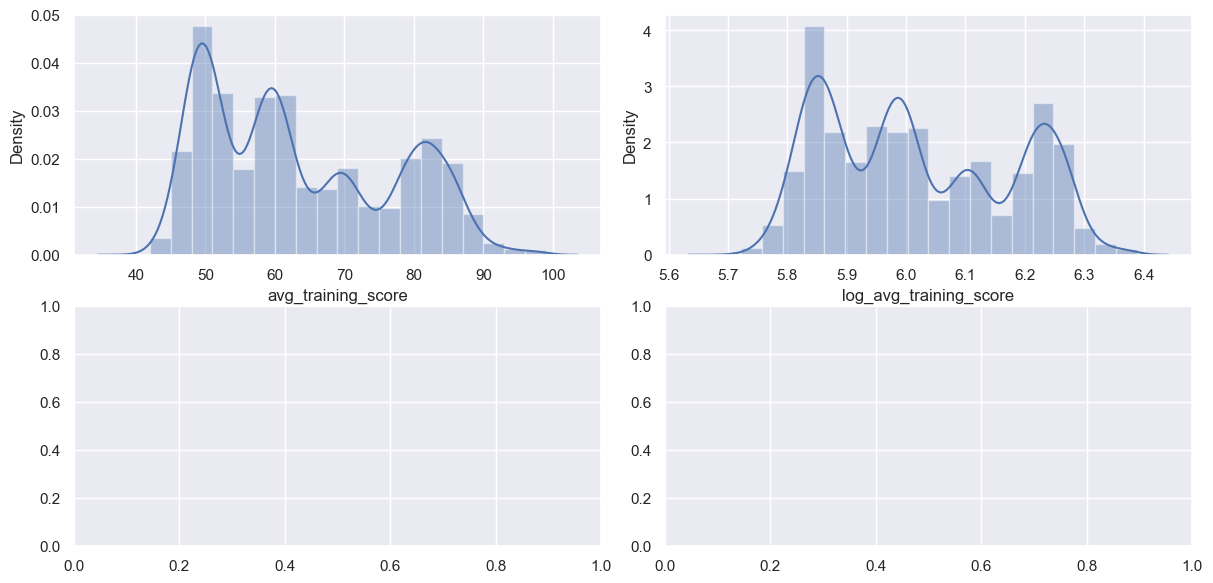

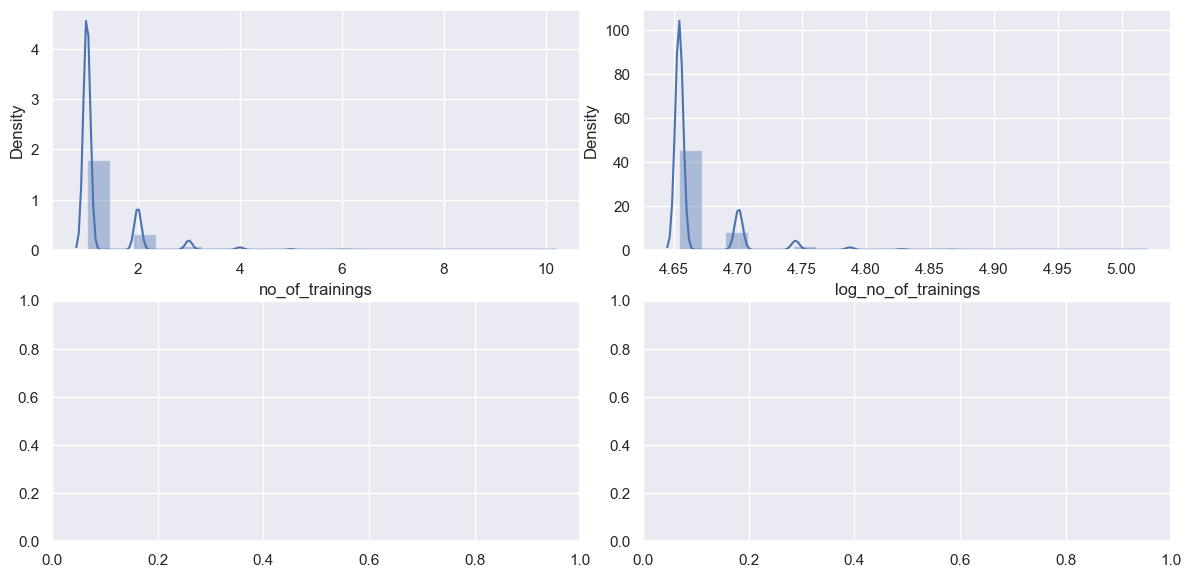

In [59]:
train['log_avg_training_score'] = pd.DataFrame(np.log(train['avg_training_score'] * 5+ 100))

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(train['avg_training_score'], kde = True, bins = 20,ax=ax1)
sns.distplot(train['log_avg_training_score'],kde = True, bins = 20,ax=ax2)

train['log_no_of_trainings'] = pd.DataFrame(np.log(train['no_of_trainings'] * 5 + 100))

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(train['no_of_trainings'], kde = True, bins = 20,ax=ax1)
sns.distplot(train['log_no_of_trainings'],kde = True, bins = 20,ax=ax2)

From the above graphs, we can see that using log transform the right skewed variables have normalized to an extent. 

In [60]:
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score',
 'gender_count',
 'region_count',
 'department_count',
 'recruitment_channel_count']

In [61]:
to_add = ['log_no_of_trainings','log_avg_training_score']
to_drop = ['no_of_trainings','avg_training_score']
train.drop(to_drop,axis=1,inplace=True)

# changing num_cols values
for col in to_drop:
  num_cols.remove(col)

for col in to_add:
  num_cols.append(col)

print(num_cols)

['age', 'previous_year_rating', 'length_of_service', 'gender_count', 'region_count', 'department_count', 'recruitment_channel_count', 'log_no_of_trainings', 'log_avg_training_score']


In [62]:
train[num_cols].isnull().sum()

age                          0
previous_year_rating         0
length_of_service            0
gender_count                 0
region_count                 0
department_count             0
recruitment_channel_count    0
log_no_of_trainings          0
log_avg_training_score       0
dtype: int64

# Splitting and Normalizing the data


In [63]:
## shuffle the DataFrame rows 
train = train.sample(frac = 1,random_state=100)

Train:Test:Valid will be divided into 60:20:20 ratio

In [64]:
X = train.drop([target],axis=1)
y = train[target]

#saving column names
columns = X.columns

#divide into train-valid and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 101, stratify=y,test_size=0.2)

#divide into train and valid sets
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, random_state = 101, stratify=y_train,test_size=0.25)

In [66]:
#retaining copy of old data
X_train_old = X_train.copy()
X_test_old = X_test.copy()
X_valid_old = X_valid.copy()
X_train[num_cols] = ut.min_max_normalization(X_train[num_cols])
X_test[num_cols] = ut.min_max_normalization(X_test[num_cols])
X_valid[num_cols] = ut.min_max_normalization(X_valid[num_cols])

In [67]:
X_train.shape,X_test.shape,X_valid.shape

((32884, 36), (10962, 36), (10962, 36))

Pickle files can be loaded from pickle files folder. One can enter the path accordingly

In [68]:
# Uncomment to save above processed data, one can change filepath for dumping data

# filename = 'X_train.sav'
# pickle.dump(X_train, open(filename, 'wb'))

# filename = 'X_test.sav'
# pickle.dump(X_test, open(filename, 'wb'))

# filename = 'X_valid.sav'
# pickle.dump(X_valid, open(filename, 'wb'))

# filename = 'y_train.sav'
# pickle.dump(y_train, open(filename, 'wb'))

# filename = 'y_test.sav'
# pickle.dump(y_test, open(filename, 'wb'))

# filename = 'y_valid.sav'
# pickle.dump(y_valid, open(filename, 'wb'))

# Model Selection


If the difference between 2 classes is large, it's an imbalanced dataset.

In [69]:
train[target].value_counts(normalize=True) * 100

is_promoted
0    91.482995
1     8.517005
Name: proportion, dtype: float64

Performing cross-validation to evaluate accuracy for different models.

0    91.482995

1     8.517005

Name: is_promoted, dtype: float64

We will use the f1 score to calculate the model performance, since avoiding both false positive(undeserving promotion) and false negatives(deserving employees not getting promoted) are equally improtant and we need a trade-off between precision and recall.

Pickle files can be dumped into pickle files folder. One can enter the path accordingly

In [70]:
results = ut.check_clf(X_train,y_train,'f1_macro')

filename = 'train_cv_results.sav'
pickle.dump(results, open(filename, 'wb'))

results = ut.check_clf(X_valid,y_valid,'f1_macro')

filename = 'valid_cv_results.sav'
pickle.dump(results, open(filename, 'wb'))

Name:  ComplementNB
Score:  0.5434514402295171
Name:  LGBMClassifier
Score:  0.734660181232093
Name:  CatBoostClassifier
Score:  0.7385740622867037
Name:  LogisticRegression
Score:  0.6144206687691252
Name:  DecisionTreeClassifier
Score:  0.6853146650643582
Name:  SVC
Score:  0.5917618292149386
Name:  RandomForestClassifier
Score:  0.6900413456908074
Name:  AdaBoostClassifier
Score:  0.6242053994148882
Name:  XGBClassifier
Score:  0.6036435543012983
Name:  ComplementNB
Score:  0.5408190452544916
Name:  LGBMClassifier
Score:  0.7248616463942555
Name:  CatBoostClassifier
Score:  0.7282808699088363
Name:  LogisticRegression
Score:  0.6074909483988847
Name:  DecisionTreeClassifier
Score:  0.681059822727611
Name:  SVC
Score:  0.5897048194625261
Name:  RandomForestClassifier
Score:  0.6504344849882735
Name:  AdaBoostClassifier
Score:  0.6248917031720144
Name:  XGBClassifier
Score:  0.6380994056195284


LGBM and Catboost are the 2 best performing algorithms on train and validation set. We'll try the 2 of them individually and then combine them to form an ensemble model. 

# Loading Train,Test and Valid sets

Pickle files can be loaded from pickle files folder. One can enter the path accordingly

In [71]:
#Uncomment when you need to load data directly

# filename = 'X_train.sav'
# X_train = pickle.load(open(filename, 'rb'))

# filename = 'X_test.sav'
# X_test = pickle.load(open(filename, 'rb'))

# filename = 'X_valid.sav'
# X_valid = pickle.load(open(filename, 'rb'))

# filename = 'y_train.sav'
# y_train = pickle.load(open(filename, 'rb'))

# filename = 'y_test.sav'
# y_test = pickle.load(open(filename, 'rb'))

# filename = 'y_valid.sav'
# y_valid = pickle.load(open(filename, 'rb'))

# Note: The model will be trained on train dataset and then validated on validation dataset. The test set will be used to compare performance with validation set to see if we haven't overfitted on validation set. Our goal is to keep the performance almost similar on all 3 sets, to ensure a better generalized model.

# Catboost

In [78]:
clf = CatBoostClassifier(verbose=0)
y_train_pred,y_valid_pred,y_test_pred = ut.check_clf_score(clf,X_train, y_train.values, X_valid, y_valid.values, X_test,y_test.values)

Training score:  0.7814381086603348
valid score:  0.736753441923599
test score:  0.7273661313080136

 For train set 

Actual value counts
0    30084
1     2800
Name: count, dtype: int64
Predicted value counts
0    31687
1     1197
Name: count, dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: count, dtype: int64
Predicted value counts
0    10600
1      362
Name: count, dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: count, dtype: int64
Predicted value counts
0    10633
1      329
Name: count, dtype: int64


In [79]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000], 
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100], 
          'border_count':[32,5,10,20,50,100,200]}

clf = CatBoostClassifier(verbose=0)
catboost_params = ut.random_search(clf,params,'catboost',80, X_train,y_train)

In [81]:
filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
print(catboost_params)

{'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4, 'border_count': 100}


In [82]:
clf = CatBoostClassifier(verbose=0,**catboost_params)
y_train_pred,y_valid_pred,y_test_pred = ut.check_clf_score(clf, X_train, y_train.values, X_valid, y_valid.values, X_test,y_test.values)

Training score:  0.7483263494165266
valid score:  0.7384244093381395
test score:  0.7272348762104472

 For train set 

Actual value counts
0    30084
1     2800
Name: count, dtype: int64
Predicted value counts
0    31844
1     1040
Name: count, dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: count, dtype: int64
Predicted value counts
0    10615
1      347
Name: count, dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: count, dtype: int64
Predicted value counts
0    10644
1      318
Name: count, dtype: int64


In [83]:
#save columns selected, since we selected all columns, we'll save the columns variables selected earlier
filename = 'columns_selected'
pickle.dump(columns, open(filename, 'wb'))

## F1 score optimization

In [84]:
clf = CatBoostClassifier(verbose=0,**catboost_params)
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}
y_train_pred, y_valid_pred = ut.run_gradient_boosting(clf, fit_params, X_train,y_train,X_valid,y_valid)

0:	learn: 0.4322038	test: 0.4327398	best: 0.4327398 (0)	total: 41.6ms	remaining: 4.11s
99:	learn: 0.1527247	test: 0.1657205	best: 0.1656300 (86)	total: 4.98s	remaining: 0us

bestTest = 0.1656300482
bestIteration = 86

Shrink model to first 87 iterations.


Best Threshold:  0.26
Best Score:  0.07846653962560252


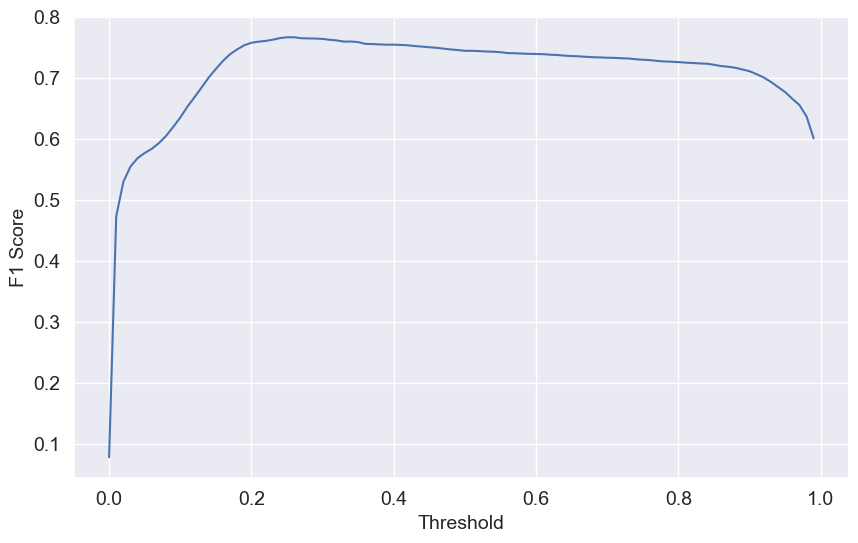

In [85]:
ut.get_optimal_f1_thresh(y_train.values, y_train_pred)

Best Threshold:  0.4
Best Score:  0.0785137861466039


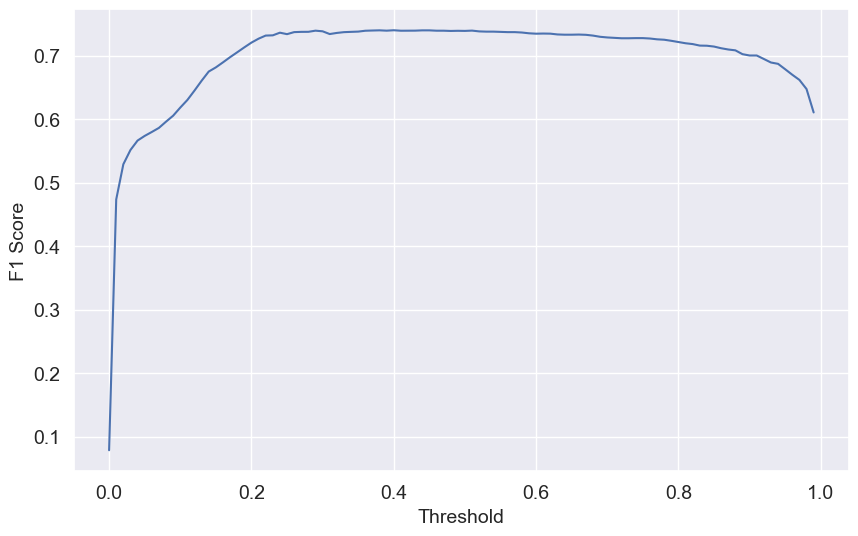

In [86]:
ut.get_optimal_f1_thresh(y_valid.values, y_valid_pred)

Looking at the graphs above, we can select 0.25 as optimal threshold 

In [87]:
y_train_pred =  clf.predict_proba(X_train)[:, 1]
optimal_thresh = 0.25
y_train_pred_rounded = (y_train_pred > optimal_thresh) * 1
train_score = f1_score(y_train.values, y_train_pred_rounded, average='macro')
print(train_score)

0.7668024926572777


In [88]:
y_valid_pred =  clf.predict_proba(X_valid)[:, 1]
optimal_thresh = 0.25
y_valid_pred_rounded = (y_valid_pred > optimal_thresh) * 1
valid_score = f1_score(y_valid.values, y_valid_pred_rounded, average='macro')
print(valid_score)

0.7337506990617038


In [89]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.25
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test.values, y_test_pred_rounded, average='macro')
print(test_score)

0.7378065304205811


The train,test and valid scores are all between 0.73 and 0.77. Therefore, we can say that the proper parameters have been selected.

# LightGBM


In [90]:
clf = LGBMClassifier(class_weight='balanced')
y_train_pred,y_valid_pred,y_test_pred = ut.check_clf_score(clf, X_train, y_train.values, X_valid, y_valid.values, X_test,y_test.values)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 32884, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training score:  0.6590041638990993
valid score:  0.6207629431154338
test score:  0.6212455944698336

 For train set 

Actual value counts
0    30084
1     2800
Name: count, dtype: int64
Predicted value counts
0    23514
1     9370
Name: count, dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: count, dtype: int64
Predicted value

## Hyperparameter Tuning

In [91]:
params = {
    'boosting_type':['gbdt','dart','rf'],
    'n_estimators': [250,500],
    'num_leaves': [100,150],
    'learning_rate': [0.01,0.1,0.5,1],
    'max_depth': [10,12],
    'colsample_bytree':[0.5,0.75,1],
    'bagging_freq': [2,5,8],
    'bagging_fraction': [0.25,0.5,0.75,1],
    'lambda_l2': [0.5,0.6,0.7] 
}

In [92]:
clf = LGBMClassifier(class_weight='balanced')
y_train = y_train.astype('int')
lgbm_params = ut.random_search(clf,params,'lgbm',25,X_train,y_train)

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

In [94]:
filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
print(lgbm_params)

{'num_leaves': 150, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.5, 'lambda_l2': 0.5, 'colsample_bytree': 1, 'boosting_type': 'dart', 'bagging_freq': 5, 'bagging_fraction': 1}


In [95]:
clf = LGBMClassifier(class_weight='balanced',**lgbm_params)
y_train_pred,y_valid_pred,y_test_pred = ut.check_clf_score(clf, X_train, y_train.values, X_valid, y_valid.values, X_test,y_test.values) 

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[Ligh

## F1 score optimization

In [97]:
# lgb_params = {'num_leaves': 150, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.5, 'colsample_bytree': 0.75, 'boosting_type': 'gbdt'}
clf = LGBMClassifier(class_weight='balanced',**lgbm_params)
fit_params = {} #'verbose': 100,
y_train_pred, y_valid_pred = ut.run_gradient_boosting(clf, fit_params, X_train,y_train,X_valid,y_valid,True)

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

Best Threshold:  0.72
Best Score:  0.07846653962560252


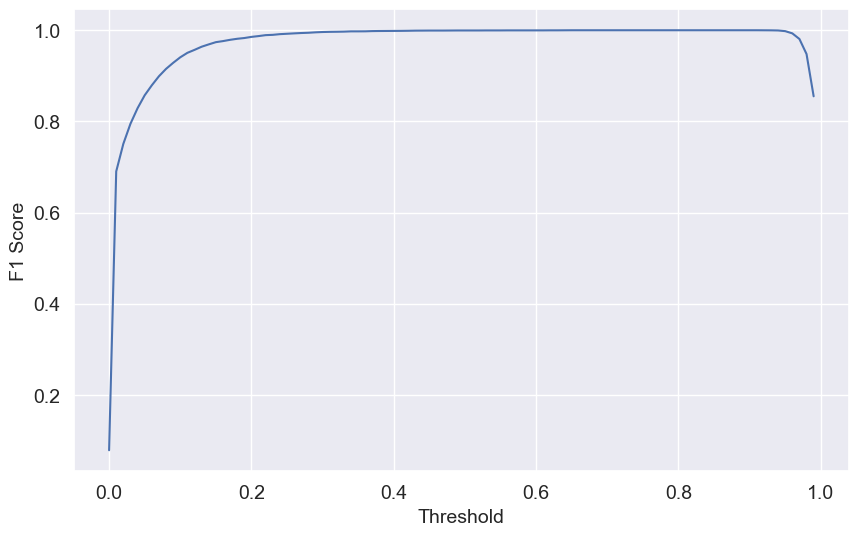

In [98]:
ut.get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.85
Best Score:  0.0785137861466039


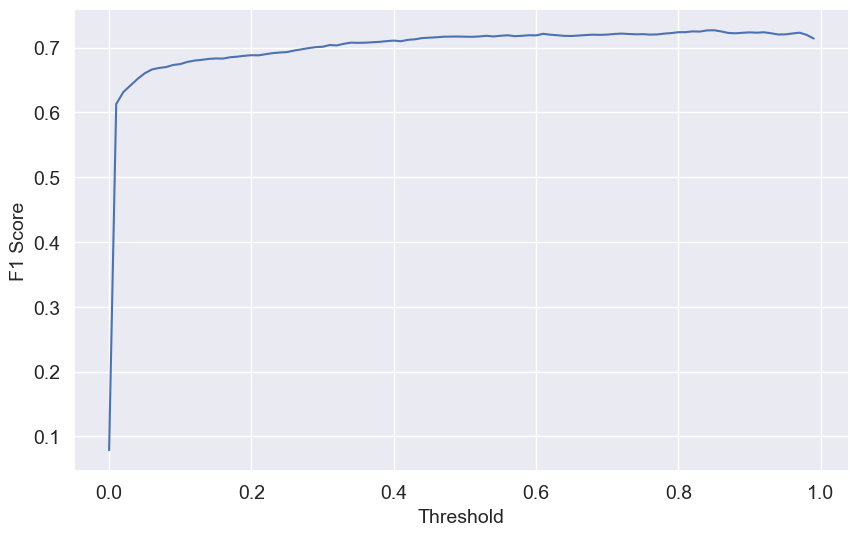

In [99]:
y_valid = y_valid.astype('int')
ut.get_optimal_f1_thresh(y_valid, y_valid_pred)

Based on above graphs, we can see that the threshold of 0.8 is the best one

In [100]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.8
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
y_test = y_test.astype('int')
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7123570739771319


# Ensembling

In [101]:
filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
clf1 = LGBMClassifier(class_weight='balanced',**lgbm_params)

filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
clf2 = CatBoostClassifier(verbose=0,**catboost_params)

In [102]:
estimators = [('lgbm', clf1),('catboost', clf2)]

In [103]:
results = {}
models = [LGBMClassifier(),CatBoostClassifier(verbose=0),XGBClassifier(random_state=96)]  
model_names = ['LGBMClassifier','CatBoostClassifier','XGBClassifier']
for i in range(len(models)):
    clf = StackingClassifier(estimators=estimators, final_estimator=models[i]) 
    results[model_names[i]] = mean(cross_val_score(clf, X_train, y_train, cv = 5, scoring='f1_macro',n_jobs=-1))
print(results)

{'LGBMClassifier': 0.7362404623067512, 'CatBoostClassifier': 0.7349529978439187, 'XGBClassifier': 0.7360590005871437}


In [104]:
results = {}

# with joblib.parallel_backend('dask'):
#   models = [LGBMClassifier(),CatBoostClassifier(verbose=0),XGBClassifier(random_state=96)]  
#   model_names = ['LGBMClassifier','CatBoostClassifier','XGBClassifier']
#   for i in range(len(models)):
#     clf = StackingClassifier(estimators=estimators, final_estimator=models[i]) 
#     results[model_names[i]] = mean(cross_val_score(clf, X_valid, y_valid, cv = 5, scoring='f1_macro',n_jobs=-1))

models = [LGBMClassifier(),CatBoostClassifier(verbose=0),XGBClassifier(random_state=96)]  
model_names = ['LGBMClassifier','CatBoostClassifier','XGBClassifier']
for i in range(len(models)):
    clf = StackingClassifier(estimators=estimators, final_estimator=models[i]) 
    results[model_names[i]] = mean(cross_val_score(clf, X_valid, y_valid, cv = 5, scoring='f1_macro',n_jobs=-1))
print(results)

2024-04-07 19:26:19,713 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'inproc://192.168.1.103/22488/4', name: 0, status: running, memory: 0, processing: 0>
2024-04-07 19:26:19,720 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'inproc://192.168.1.103/22488/4'.
2024-04-07 19:26:19,723 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


{'LGBMClassifier': 0.7199667172396037, 'CatBoostClassifier': 0.7197343371020194, 'XGBClassifier': 0.7242180631593103}


In [116]:
clf = StackingClassifier(estimators=estimators, final_estimator = CatBoostClassifier(verbose=0))
clf.fit(X_train,y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

Best Threshold:  0.22
Best Score:  0.07846653962560252


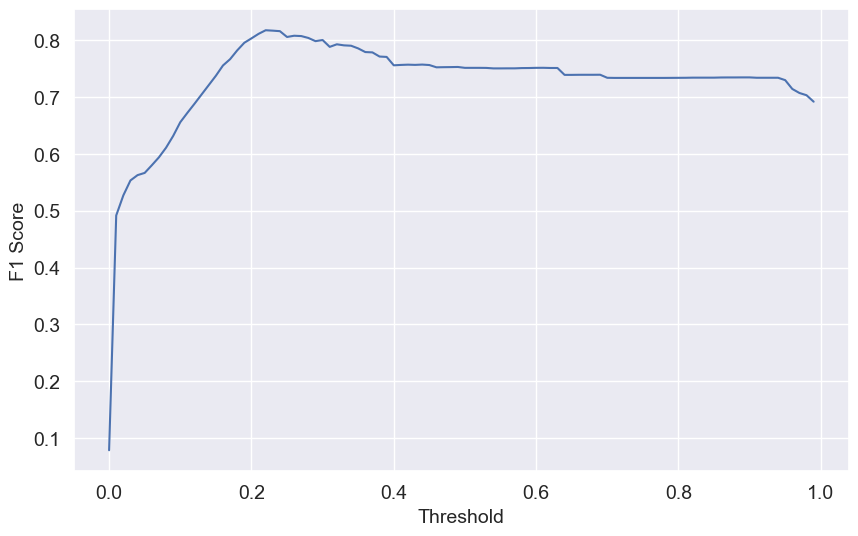

In [117]:
ut.get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.57
Best Score:  0.0785137861466039


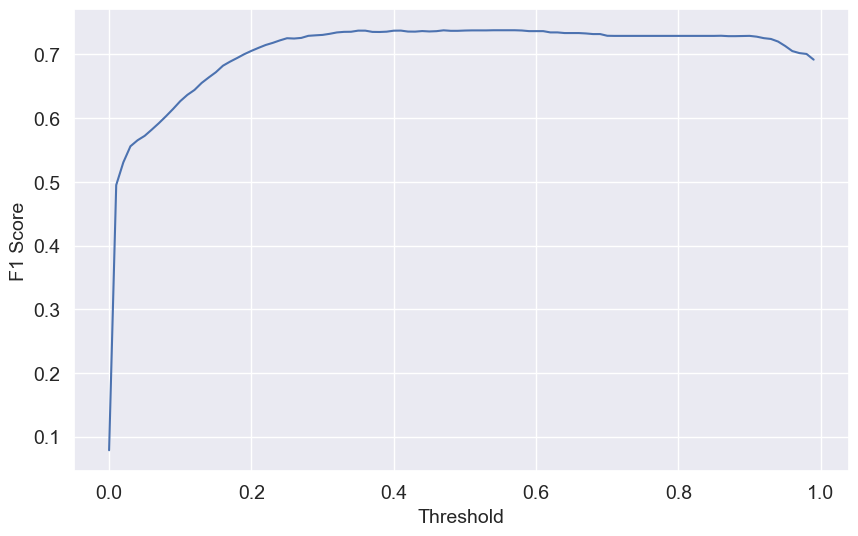

In [118]:
ut.get_optimal_f1_thresh(y_valid, y_valid_pred)

0.5 seems like the ideal threshold from above 2 graphs

In [119]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.5
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7253232269643949


The train,test and valid scores seem similar, which is okay. 

# Averaging

In [120]:
#Refernce: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

#final_pred=(pred_val_1*w1 + pred_val_2*w2)

filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
clf1 = LGBMClassifier(class_weight='balanced',**lgbm_params)

filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
clf2 = CatBoostClassifier(verbose=0,**catboost_params)

In [121]:
weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [122]:
results = {}
for w in weights:
  clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[w,1-w],flatten_transform=True)
  results[w] = mean(cross_val_score(clf, X_train, y_train, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)  

{0.1: 0.7377943037181178, 0.2: 0.7385389409178778, 0.3: 0.7401570849483787, 0.4: 0.7406251265806602, 0.5: 0.7349338352585745, 0.6: 0.7272548369573921, 0.7: 0.7244817421279033, 0.8: 0.7219113666604625, 0.9: 0.7182082919716366}


In [123]:
results = {}
for w in weights:
  clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[w,1-w],flatten_transform=True)
  results[w] = mean(cross_val_score(clf, X_valid, y_valid, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)  

{0.1: 0.7302270485216877, 0.2: 0.7322630295180739, 0.3: 0.7347110705891322, 0.4: 0.7300634432683875, 0.5: 0.7262021368905879, 0.6: 0.7244794560709195, 0.7: 0.7252565038622688, 0.8: 0.7229142671077818, 0.9: 0.7199516574550363}


The value of 0.3 seems to be giving best results for train and valid set. Hence weightage will be 0.2 for lgb and 0.8 for catboost

In [124]:
best_w = 0.3
clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[best_w,1-best_w],flatten_transform=True)
clf.fit(X_train,y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

Best Threshold:  0.3
Best Score:  0.07846653962560252


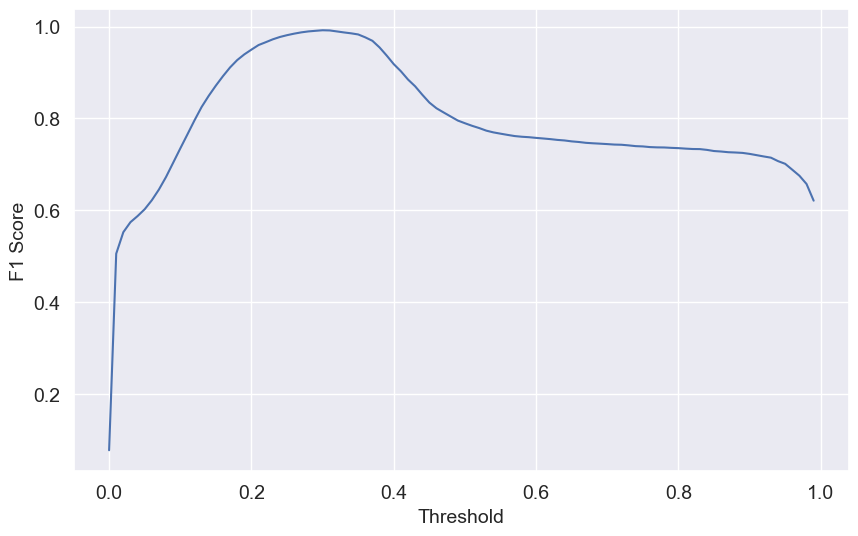

In [125]:
ut.get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.46
Best Score:  0.0785137861466039


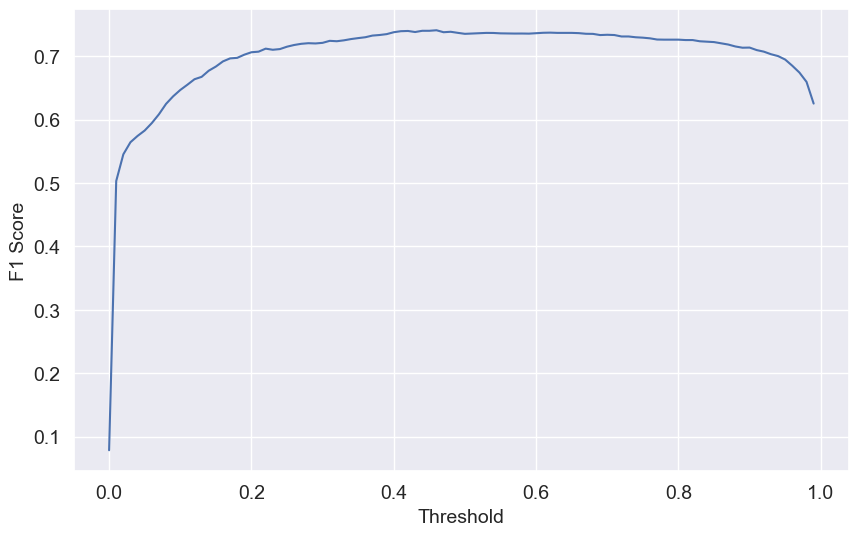

In [126]:
ut.get_optimal_f1_thresh(y_valid, y_valid_pred)

0.6 seems to be the best value according to the graphs such that it avoids overfitting

In [128]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.6
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7279230369905562


Values for train,test and valid scores are close to each other, which should be fine.